In [1]:
# !pip install numba


In [1]:
import numpy as np
from PIL import Image
from hashlib import sha256
from numba import njit


In [2]:
np.random.seed(42)  # or any fixed seed value
iv = np.random.randint(0, 256, size=16, dtype=np.uint8)
prev_cipher = iv.copy()


In [3]:
plainImg = r"C:\Users\User\Desktop\Images\256x256 grayscale\Baboon\Baboon-grayscale.png"

##  Optimized Chaotic Sequence Generator with Numba

In [4]:
def aes_g(word, round_idx, sbox, Rcon):
    # Rotate left
    word = word[1:] + word[:1]
    # Apply S-box
    word = [sbox[b // 16][b % 16] for b in word]
    # XOR with round constant
    word[0] ^= Rcon[round_idx]
    return word

def key_expansion(key, sbox, Rcon): 
    w = []
    for i in range(4):
        w.append(key[4*i : 4*(i+1)])  # initial 4 words from 16-byte key

    for i in range(4, 44):  # total 44 words for AES-128 (11 rounds × 4 words)
        temp = w[i - 1]
        if i % 4 == 0:
            temp = aes_g(temp, i // 4, sbox, Rcon)
        w.append([w[i - 4][j] ^ temp[j] for j in range(4)])
    return w


In [5]:
def logistic_map_sequence(length, x0=0.5, r=3.99, discard=100):
    """
    Generate a logistic map sequence of given length with optional discard.
    """
    x = x0
    seq = []
    for i in range(length + discard):
        x = r * x * (1 - x)
        if i >= discard:
            seq.append(x)
    return np.array(seq)


In [6]:
@njit
def logistic_tent_map_fast(x, r):
    if x < 0.5:
        return (r * x * (1 - x) + (4 - r) * x / 2) % 1
    else:
        return (r * x * (1 - x) + (4 - r) * (1 - x) / 2) % 1

@njit
def henon_map_sequence(x0=0.1, y0=0.1, a=1.4, b=0.3, length=256):
    """
    Generate a 1D chaotic sequence from a 2D Henon map.
    The output is a float array in [0, 1) scaled from x_n values.
    """
    x, y = x0, y0
    seq = []
    for _ in range(length):
        x_new = 1 - a * x**2 + y
        y_new = b * x
        x, y = x_new, y_new
        # Normalize x to [0, 1)
        seq.append(abs(x % 1))
    return np.array(seq)



In [7]:
def chaotic_xor_mask_feedback(flat_array, x0=0.5, r=3.99):
    """
    Apply feedback-based chaotic XOR masking using logistic map.
    Each byte is XORed with the chaotic value and the previous masked byte.
    """
    chaotic_seq = logistic_map_sequence(len(flat_array), x0, r)
    chaotic_bytes = (chaotic_seq * 256).astype(np.uint8)

    masked = np.zeros_like(flat_array)
    masked[0] = flat_array[0] ^ chaotic_bytes[0]
    for i in range(1, len(flat_array)):
        masked[i] = flat_array[i] ^ chaotic_bytes[i] ^ masked[i - 1]

    return masked, chaotic_bytes


In [8]:
def generate_shift_pattern_deterministic(seed: float, r: float, block_index: int):
    """
    Generate a deterministic 4-element shift pattern based on block index.
    Ensures reproducibility for encryption and decryption.
    """
    x0 = (seed + block_index * 0.0001) % 1  # vary slightly with block index
    pattern = []
    x = x0
    for _ in range(4):
        x = r * x * (1 - x)
        pattern.append(x)
    pattern = np.argsort(pattern).tolist()
    # print("pattern",pattern)
    return pattern


In [9]:
def chaotic_pixel_permutation(flat_array, x0=0.75, r=3.99):
    length = len(flat_array)
    x = x0
    seq = np.zeros(length)
    for i in range(length):
        x = r * x * (1 - x)
        seq[i] = x
    permutation = np.argsort(seq)
    # print(permutation,seq,len(seq),len(flat_array))
    return flat_array[permutation], permutation


## Fast Variable S-box Generator

In [10]:
def generate_variable_sbox_henon(x0=0.1, y0=0.1, a=1.4, b=0.3):
    """
    Generate a variable S-box using a 2D Henon chaotic map.
    """
    seq = henon_map_sequence(x0, y0, a, b, length=256)
    indices = np.argsort(seq)
    sbox = indices.reshape((16, 16))
    return sbox, (x0 + 0.01) % 1, (y0 + 0.01) % 1  # evolve seeds


## AES Core Functions (ShiftRows, MixColumns, AddRoundKey)

In [11]:
def shift_rows_variable(state, shift_pattern):
    """
    Shift each row of the AES state matrix by the amount specified in shift_pattern.

    Args:
        state: 4x4 AES state matrix.
        shift_pattern: List of 4 integers specifying the number of positions to shift each row.

    Returns:
        A new state matrix with rows shifted accordingly.
    """
    return [
        state[row][shift_pattern[row]:] + state[row][:shift_pattern[row]]
        for row in range(4)
    ]


def mix_columns(state):
    def gmul(a, b):
        p = 0
        for _ in range(8):
            if b & 1: p ^= a
            high_bit = a & 0x80
            a = (a << 1) & 0xFF
            if high_bit: a ^= 0x1B
            b >>= 1
        return p
    result = [[0]*4 for _ in range(4)]
    for c in range(4):
        result[0][c] = gmul(0x02, state[0][c]) ^ gmul(0x03, state[1][c]) ^ state[2][c] ^ state[3][c]
        result[1][c] = state[0][c] ^ gmul(0x02, state[1][c]) ^ gmul(0x03, state[2][c]) ^ state[3][c]
        result[2][c] = state[0][c] ^ state[1][c] ^ gmul(0x02, state[2][c]) ^ gmul(0x03, state[3][c])
        result[3][c] = gmul(0x03, state[0][c]) ^ state[1][c] ^ state[2][c] ^ gmul(0x02, state[3][c])
    return result

def add_round_key(state, round_key):
    return [[state[row][col] ^ round_key[row][col] for col in range(4)] for row in range(4)]

def word_list_to_matrix(words):
    assert len(words) == 4 and all(len(w) == 4 for w in words), "Expected 4x4 matrix"
    return [[words[row][col] for col in range(4)] for row in range(4)]


In [12]:
def aes_encrypt_block(plain_block, key, sbox,shift_pattern):
    Rcon = [0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36]
    round_keys = key_expansion(key, sbox, Rcon)

    # Convert to 4x4 state matrix
    state = [plain_block[i:i+4] for i in range(0, 16, 4)]

    # Initial AddRoundKey
    state = add_round_key(state, word_list_to_matrix(round_keys[0:4]))

    # Rounds 1 to 9
    for round in range(1, 10):
        state = [[sbox[byte // 16][byte % 16] for byte in row] for row in state]  # SubBytes
        state = shift_rows_variable(state, shift_pattern)

        state = mix_columns(state)
        state = add_round_key(state, word_list_to_matrix(round_keys[round*4:(round+1)*4]))

    # Final Round (no MixColumns)
    state = [[sbox[byte // 16][byte % 16] for byte in row] for row in state]
    state = shift_rows_variable(state, shift_pattern)

    state = add_round_key(state, word_list_to_matrix(round_keys[40:44]))

    # Flatten and return
    return [state[i][j] for i in range(4) for j in range(4)]


In [13]:
def get_combined_seed(image_path, key):
    with open(image_path, 'rb') as f:
        image_data = f.read()
    combined = image_data + bytes(key)
    h = hashlib.sha256(combined).hexdigest()
    return int(h[:8], 16) / 0xFFFFFFFF


## Encrypt Image with Variable S-box Every N Blocks

In [14]:
from PIL import Image
import numpy as np

def encrypt_image_variable_sbox_chunked(image_path, output_path, key, shift_pattern=None, sbox_interval=1, x0_mask=0.5, r_mask=3.99):
    # Load image in correct mode
    img = Image.open(image_path).convert("L")
    # Grayscale
    img_np = np.array(img)
    print(len(img_np))
    h, w = img_np.shape
    c = 1  # single channel
    
    total_pixels = h * w * c
    flat = img_np.flatten().copy()
    print(len(flat))

    # Pad to multiple of 16 bytes
    padding = (-len(flat)) % 16
    flat = np.concatenate([flat, np.zeros(padding, dtype=np.uint8)])

    # Apply chaotic pixel permutation
    flat, perm_indices = chaotic_pixel_permutation(flat, x0=0.75, r=3.99)

    # Apply XOR chaotic mask
    # Apply enhanced chaotic mask with feedback diffusion
    flat, final_x_mask = chaotic_xor_mask_feedback(flat, x0=x0_mask, r=r_mask)


    # Split into 16-byte blocks
    blocks = [list(flat[i:i+16]) for i in range(0, len(flat), 16)]

    # CBC Mode: initialize IV and prev_cipher
    # iv = np.random.randint(0, 256, size=16, dtype=np.uint8)
    prev_cipher = iv.copy()
    seed = get_combined_seed(image_path, key)
    encrypted_blocks = []
    x0, y0 = 0.1, 0.1  # Initial seeds for Henon map

    for i, block in enumerate(blocks):
        if i % sbox_interval == 0:
            sbox, x0, y0 = generate_variable_sbox_henon(x0, y0)

        # CBC XOR chaining
        block = [b ^ c for b, c in zip(block, prev_cipher)]

        shift_pattern = generate_shift_pattern_deterministic(seed, r=3.99, block_index=i)
        cipher_block = aes_encrypt_block(block, key, sbox, shift_pattern)
        encrypted_blocks.append(cipher_block)

        prev_cipher = cipher_block
    
    # Post-cipher block chaining (extra diffusion)
    for i in range(1, len(encrypted_blocks)):
        encrypted_blocks[i] = [a ^ b for a, b in zip(encrypted_blocks[i], encrypted_blocks[i - 1])]

    # Flatten encrypted output
    flat_enc = np.array([b for block in encrypted_blocks for b in block], dtype=np.uint8)[:total_pixels]

    # Reshape and save encrypted image
    encrypted_img = flat_enc.reshape((h, w))
    Image.fromarray(encrypted_img.astype(np.uint8), mode="L").save(output_path)


    # Return metadata for decryption
    return {
        "padding": padding,
        "original_shape": (h, w, c),
        "initial_x0": 0.1,
        "initial_y0": 0.1,
        "x0_mask": x0_mask,
        "r_mask": r_mask,
        "perm_indices": perm_indices.tolist(),
        "iv": iv.tolist(), # ⬅️ CBC IV added
        "seed": seed
    }


In [15]:
key = [0x2b, 0x7e, 0x15, 0x16,
       0x28, 0xae, 0xd2, 0xa6,
       0xab, 0xf7, 0x15, 0x88,
       0x09, 0xcf, 0x4f, 0x3c]

# np.random.seed(42)  # Optional for reproducibility
# key = np.random.randint(0, 256, size=16, dtype=np.uint8).tolist()
# key


In [16]:
import hashlib


In [17]:
meta = encrypt_image_variable_sbox_chunked(
    plainImg,
    "encrypted_baboon.png",
    key,
    
    sbox_interval=1,
    x0_mask=0.5,
    r_mask=3.99
    
)


256
65536


In [18]:
encryImg = r"encrypted_baboon.png"

In [19]:
from scipy.fft import fft
import numpy as np

def bool_function_from_sbox(sbox, output_bit_idx):
    """Return truth table for the output bit of index `output_bit_idx`."""
    return [(sbox[x] >> output_bit_idx) & 1 for x in range(256)]

def walsh_transform(f):
    """Compute the Walsh spectrum using fast transform."""
    f = np.array([1 if bit else -1 for bit in f], dtype=np.int32)
    n = len(f)
    h = 1
    while h < n:
        for i in range(0, n, h*2):
            for j in range(i, i+h):
                x, y = f[j], f[j+h]
                f[j] = x + y
                f[j+h] = x - y
        h *= 2
    return f

def calculate_nonlinearity(sbox):
    nonlinearities = []
    for i in range(8):  # 8 output bits
        f = bool_function_from_sbox(sbox, i)
        w = walsh_transform(f)
        nl = 128 - max(abs(w)) // 2
        nonlinearities.append(nl)
    return nonlinearities, np.mean(nonlinearities)


In [20]:
def calculate_sac(sbox):
    sac_matrix = np.zeros((8, 8))  # input bit i → output bit j

    for input_bit in range(8):
        for x in range(256):
            x_flipped = x ^ (1 << input_bit)
            y1 = sbox[x]
            y2 = sbox[x_flipped]
            diff = y1 ^ y2
            for output_bit in range(8):
                if (diff >> output_bit) & 1:
                    sac_matrix[input_bit][output_bit] += 1

    sac_matrix /= 256
    return sac_matrix  # Values should be close to 0.5


In [21]:
def calculate_bic(sbox):
    # BIC-SAC part
    n = 8
    bic_matrix = np.zeros((n, n))
    for input_bit in range(n):
        output_change_counts = np.zeros((n,), dtype=np.int32)
        for x in range(256):
            x_flipped = x ^ (1 << input_bit)
            y1 = sbox[x]
            y2 = sbox[x_flipped]
            diff = y1 ^ y2
            bits = [(diff >> b) & 1 for b in range(n)]
            for i in range(n):
                for j in range(i+1, n):
                    if bits[i] != bits[j]:
                        bic_matrix[i][j] += 1
                        bic_matrix[j][i] += 1

    bic_matrix /= 256
    return bic_matrix


In [22]:
def calculate_dp(sbox):
    delta_in = np.zeros((256, 256), dtype=int)
    for x in range(256):
        for dx in range(1, 256):
            dy = sbox[x] ^ sbox[x ^ dx]
            delta_in[dx][dy] += 1
    max_dp = np.max(delta_in) / 256
    return max_dp


In [23]:
def calculate_lp(sbox):
    max_bias = 0
    for a in range(1, 256):
        for b in range(1, 256):
            count = 0
            for x in range(256):
                lin_in = bin(x & a).count('1') % 2
                lin_out = bin(sbox[x] & b).count('1') % 2
                if lin_in == lin_out:
                    count += 1
            bias = abs(count - 128)
            if bias > max_bias:
                max_bias = bias
    return max_bias / 256


In [24]:
def entropy(sbox):
    hist, _ = np.histogram(sbox, bins=256, range=(0, 256), density=True)
    hist = hist[hist > 0]
    return -np.sum(hist * np.log2(hist))


In [25]:
sbox_2d, _, _ = generate_variable_sbox_henon()

# Flatten to 1D and ensure integer type for analysis
sbox = sbox_2d.flatten().astype(np.uint8)

nl_vals, nl_avg = calculate_nonlinearity(sbox)
sac_matrix = calculate_sac(sbox)
bic = calculate_bic(sbox)
dp = calculate_dp(sbox)
lp = calculate_lp(sbox)
ent = entropy(sbox)

print("Nonlinearity (per output bit):", nl_vals)
print("Average Nonlinearity:", nl_avg)
print("SAC matrix:\n", sac_matrix)
print("Max SAC offset from 0.5:", np.max(np.abs(sac_matrix - 0.5)))
print("BIC matrix:\n", bic)
print("Max DP:", dp)
print("Max LP:", lp)
print("Entropy:", ent)

Nonlinearity (per output bit): [np.int32(106), np.int32(106), np.int32(108), np.int32(104), np.int32(104), np.int32(102), np.int32(102), np.int32(104)]
Average Nonlinearity: 104.5
SAC matrix:
 [[0.546875 0.5      0.5      0.5      0.53125  0.46875  0.59375  0.453125]
 [0.46875  0.53125  0.546875 0.546875 0.5      0.46875  0.5      0.46875 ]
 [0.546875 0.46875  0.546875 0.515625 0.46875  0.453125 0.5625   0.515625]
 [0.484375 0.515625 0.484375 0.53125  0.5      0.453125 0.484375 0.546875]
 [0.46875  0.53125  0.5      0.453125 0.515625 0.5625   0.5      0.46875 ]
 [0.46875  0.5      0.53125  0.484375 0.5      0.46875  0.53125  0.46875 ]
 [0.5      0.5      0.53125  0.46875  0.578125 0.46875  0.53125  0.515625]
 [0.515625 0.46875  0.5      0.390625 0.484375 0.484375 0.53125  0.46875 ]]
Max SAC offset from 0.5: 0.109375
BIC matrix:
 [[0.       4.0625   3.96875  3.8125   3.765625 4.140625 4.09375  3.9375  ]
 [4.0625   0.       4.03125  4.15625  4.015625 3.9375   4.09375  3.796875]
 [3.96875

In [26]:
def chaotic_xor_unmask_feedback(masked_array, x0=0.5, r=3.99):
    """
    Reverse feedback-based XOR masking using the same logistic map.
    """
    chaotic_seq = logistic_map_sequence(len(masked_array), x0, r)
    chaotic_bytes = (chaotic_seq * 256).astype(np.uint8)

    unmasked = np.zeros_like(masked_array)
    unmasked[0] = masked_array[0] ^ chaotic_bytes[0]
    for i in range(1, len(masked_array)):
        unmasked[i] = masked_array[i] ^ chaotic_bytes[i] ^ masked_array[i - 1]

    return unmasked


In [27]:
def reverse_permutation(permuted_array, perm_indices):
    original = np.empty_like(permuted_array)
    original[perm_indices] = permuted_array
    return original


In [28]:
def invert_sbox(sbox):
    inverse = np.zeros(256, dtype=np.uint8)
    flat_sbox = sbox.flatten()
    for i in range(256):
        inverse[flat_sbox[i]] = i
    return inverse.reshape((16, 16))

def inv_sub_bytes(state, inv_sbox):
    for i in range(4):
        for j in range(4):
            byte = state[i][j]
            row = byte // 16
            col = byte % 16
            state[i][j] = inv_sbox[row][col]
    return state


In [29]:
def inverse_shift_rows_variable(state, shift_pattern):
    
    return [
        state[row][-shift_pattern[row]:] + state[row][:-shift_pattern[row]]
        for row in range(4)
    ]


In [30]:
def inv_mix_columns(state):
    def gmul(a, b):
        p = 0
        for _ in range(8):
            if b & 1:
                p ^= a
            hi_bit_set = a & 0x80
            a = (a << 1) & 0xFF
            if hi_bit_set:
                a ^= 0x1B
            b >>= 1
        return p

    result = [[0]*4 for _ in range(4)]
    for c in range(4):
        result[0][c] = gmul(state[0][c], 0x0e) ^ gmul(state[1][c], 0x0b) ^ gmul(state[2][c], 0x0d) ^ gmul(state[3][c], 0x09)
        result[1][c] = gmul(state[0][c], 0x09) ^ gmul(state[1][c], 0x0e) ^ gmul(state[2][c], 0x0b) ^ gmul(state[3][c], 0x0d)
        result[2][c] = gmul(state[0][c], 0x0d) ^ gmul(state[1][c], 0x09) ^ gmul(state[2][c], 0x0e) ^ gmul(state[3][c], 0x0b)
        result[3][c] = gmul(state[0][c], 0x0b) ^ gmul(state[1][c], 0x0d) ^ gmul(state[2][c], 0x09) ^ gmul(state[3][c], 0x0e)
    return result


In [31]:
def aes_decrypt_block(cipher_block, key, sbox,shift_pattern):
    inv_sbox = invert_sbox(sbox)

    Rcon = [0x00, 0x01, 0x02, 0x04, 0x08, 0x10, 0x20, 0x40, 0x80, 0x1B, 0x36]
    round_keys = key_expansion(key, sbox, Rcon)

    # Convert cipher_block to 4x4 state
    state = [cipher_block[i:i+4] for i in range(0, 16, 4)]

    # Initial AddRoundKey (Round 10)
    state = add_round_key(state, word_list_to_matrix(round_keys[40:44]))
    state = inverse_shift_rows_variable(state, shift_pattern)

    state = inv_sub_bytes(state, inv_sbox)

    # Rounds 9 to 1
    for round in range(9, 0, -1):
        state = add_round_key(state, word_list_to_matrix(round_keys[round*4:(round+1)*4]))
        state = inv_mix_columns(state)
        state = inverse_shift_rows_variable(state, shift_pattern)

        state = inv_sub_bytes(state, inv_sbox)

    # Final Round (Round 0)
    state = add_round_key(state, word_list_to_matrix(round_keys[0:4]))

    # Flatten state
    return [state[i][j] for i in range(4) for j in range(4)]


In [32]:
key = [0x2b, 0x7e, 0x15, 0x16,
       0x28, 0xae, 0xd2, 0xa6,
       0xab, 0xf7, 0x15, 0x88,
       0x09, 0xcf, 0x4f, 0x3c]

# The shape of the original image (before encryption)
original_shape = (275, 183, 3)  # change this to your actual image shape
total_pixels = np.prod(original_shape)
padded_len = ((total_pixels + 15) // 16) * 16
padding = padded_len - total_pixels


In [33]:
from PIL import Image
import numpy as np

def decrypt_image_variable_sbox_chunked(encrypted_path, output_path, key, meta, sbox_interval=1):
    
    h, w, c = meta["original_shape"]
    print(h,w,c)
    print(encrypted_path)
    

    # Load encrypted image in correct mode
    if c == 1:
        img = Image.open(encrypted_path).convert("L")
    else:
        img = Image.open(encrypted_path).convert("RGB")

    img_np = np.array(img)
    total_pixels = h * w * c
    seed = meta["seed"]


    # Flatten and restore padding
    flat_enc = img_np.flatten().copy()
    padding = meta["padding"]
    flat_enc = np.concatenate([flat_enc, np.zeros(padding, dtype=np.uint8)])

    # Split into 16-byte blocks
    blocks = [list(flat_enc[i:i+16]) for i in range(0, len(flat_enc), 16)]
    for i in range(len(blocks) - 1, 0, -1):
        blocks[i] = [a ^ b for a, b in zip(blocks[i], blocks[i - 1])]
    

    decrypted_blocks = []
    x0, y0 = meta["initial_x0"], meta["initial_y0"]
    prev_cipher = np.array(meta["iv"], dtype=np.uint8)

    for i, block in enumerate(blocks):
        if i % sbox_interval == 0:
            sbox, x0, y0 = generate_variable_sbox_henon(x0, y0)

        shift_pattern = generate_shift_pattern_deterministic(seed, r=3.99, block_index=i)
        plain_block = aes_decrypt_block(block, key, sbox, shift_pattern)

        # CBC chaining: XOR decrypted block with previous cipher block
        plain_block = [b ^ c for b, c in zip(plain_block, prev_cipher)]
        decrypted_blocks.append(plain_block)

        # Update chaining
        prev_cipher = block

    # Flatten the output
    flat_dec = np.array([b for block in decrypted_blocks for b in block], dtype=np.uint8)

    # Undo XOR mask using feedback unmasking
    flat_dec = chaotic_xor_unmask_feedback(flat_dec, x0=meta["x0_mask"], r=meta["r_mask"])


    # Undo permutation
    inverse_perm = np.argsort(meta["perm_indices"])
    flat_dec = flat_dec[inverse_perm]

    # Trim padding
    flat_dec = flat_dec[:total_pixels]

    # Reshape and save decrypted image
    if c == 1:
        decrypted_img = flat_dec.reshape((h, w))
    else:
        decrypted_img = flat_dec.reshape((h, w, c))

    Image.fromarray(decrypted_img.astype(np.uint8)).save(output_path, format="PNG")
    img_to_show = Image.fromarray(decrypted_img.astype(np.uint8))
    img_to_show.show()

    return decrypted_img


In [35]:

decrypt_image_variable_sbox_chunked(
    encrypted_path=encryImg,
    output_path="decrypted_baboon.png",
    key=key,
    meta={
        "original_shape": meta["original_shape"],
        "padding": meta["padding"],
        "seed": meta["seed"],
        "initial_x0": 0.1,
        "initial_y0": 0.1,
        "x0_mask": 0.5,
        "r_mask": 3.99,
        "perm_indices": meta["perm_indices"],
        "iv": meta["iv"]  
    },
    sbox_interval=1
)







256 256 1
encrypted_baboon.png


array([[ 92,  55,  74, ...,  85, 113, 135],
       [ 88,  68,  62, ...,  98,  83,  78],
       [ 79,  95,  65, ...,  82,  79, 106],
       ...,
       [104, 132, 132, ...,  92,  87,  79],
       [130, 134, 127, ...,  89,  87,  83],
       [ 69,  67,  58, ...,  43,  39,  35]], shape=(256, 256), dtype=uint8)

In [419]:
# !pip install scikit-image


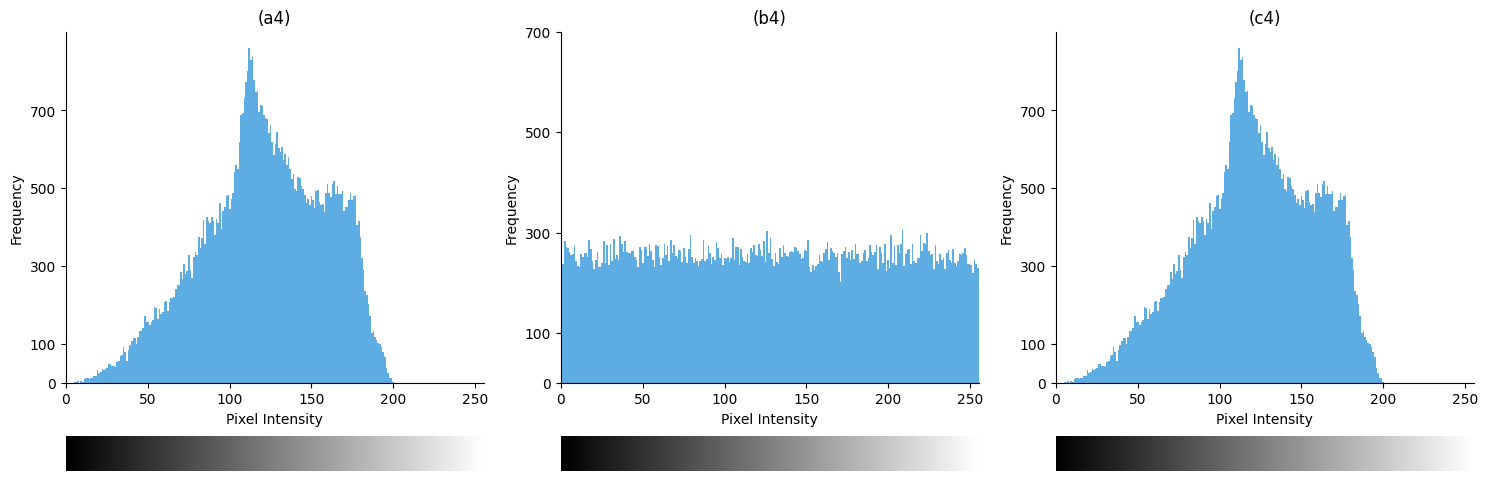

In [37]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# --- Load Images ---
# Replace with your actual file paths
orig_img = np.array(Image.open(plainImg).convert("L"))
cipher_img = np.array(Image.open(encryImg).convert("L"))
decrypted_img = np.array(Image.open("decrypted_baboon.png").convert("L"))

images = [orig_img, cipher_img, decrypted_img]
titles = ["(a4)", "(b4)", "(c4)"]

# --- Create Figure ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(3):
    ax = axes[i]

    # Plot histogram in light blue
    ax.hist(images[i].ravel(), bins=256, range=(0, 255), color='#5DADE2', edgecolor='none')
    ax.set_xlim(0, 255)
    ax.set_xticks([0, 50, 100, 150, 200, 250])
    ax.set_yticks([0, 100, 300, 500, 700])
    ax.set_title(titles[i], fontsize=12)

    # Add axis labels
    ax.set_xlabel("Pixel Intensity")
    ax.set_ylabel("Frequency")

    # Remove top/right borders
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add grayscale bar directly below histogram
    gray_bar = np.tile(np.arange(256, dtype=np.uint8), (20, 1))  # 20-pixel tall grayscale strip
    inset = ax.inset_axes([0, -0.25, 1, 0.1])  # [x0, y0, width, height]
    inset.imshow(gray_bar, cmap='gray', aspect='auto')
    inset.axis('off')

# --- Layout & Save ---
plt.tight_layout()
plt.savefig("histograms_camera_with_labels_and_graybar.png", dpi=300, bbox_inches='tight')
plt.show()

In [423]:
##correlation Diagram

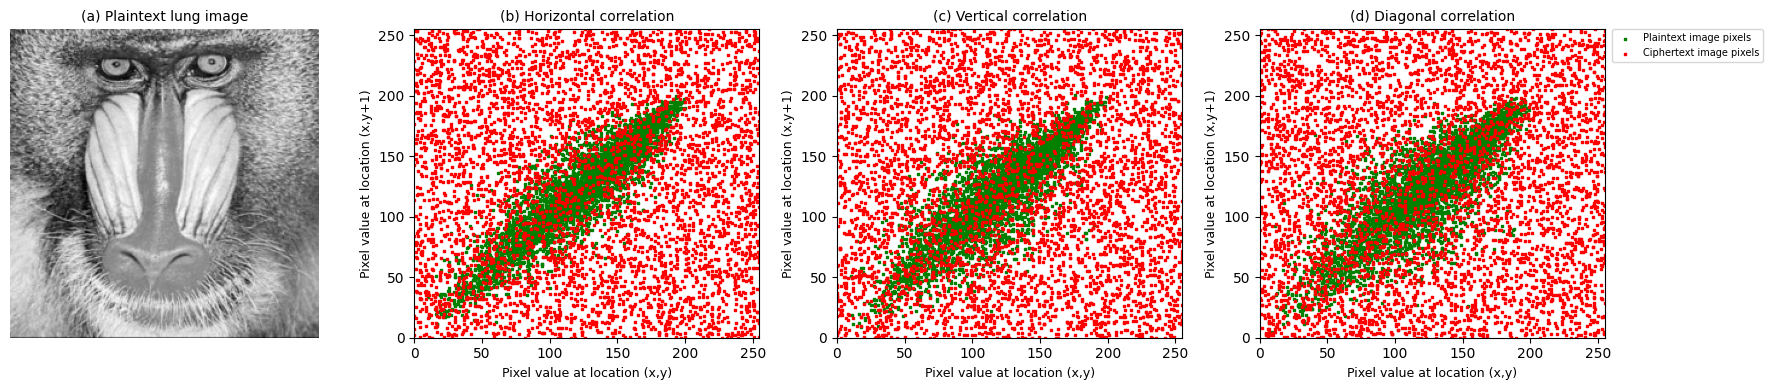

In [41]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random

# --- Load images (must be grayscale) ---
plain_img = np.array(Image.open(r"C:\Users\User\Desktop\Images\256x256 grayscale\Baboon\Baboon-grayscale.png").convert("L"))
cipher_img = np.array(Image.open("encrypted_baboon.png").convert("L"))

# --- Helper to Extract Pixel Pairs for Correlation ---
def get_pixel_pairs(img, direction='horizontal', num_samples=5000):
    h, w = img.shape
    x_vals, y_vals = [], []
    for _ in range(num_samples):
        if direction == 'horizontal':
            i = random.randint(0, h - 1)
            j = random.randint(0, w - 2)
            x, y = img[i, j], img[i, j + 1]
        elif direction == 'vertical':
            i = random.randint(0, h - 2)
            j = random.randint(0, w - 1)
            x, y = img[i, j], img[i + 1, j]
        elif direction == 'diagonal':
            i = random.randint(0, h - 2)
            j = random.randint(0, w - 2)
            x, y = img[i, j], img[i + 1, j + 1]
        x_vals.append(x)
        y_vals.append(y)
    return np.array(x_vals), np.array(y_vals)

# --- Layout Configuration ---
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
fig.subplots_adjust(wspace=0.4)

# (a) Plain Image
axes[0].imshow(plain_img, cmap='gray')
axes[0].set_title("(a) Plaintext lung image", fontsize=10)
axes[0].axis('off')

# (b), (c), (d) Correlation Plots
directions = ['horizontal', 'vertical', 'diagonal']

labels = ["(b) Horizontal correlation", "(c) Vertical correlation", "(d) Diagonal correlation"]
for i in range(3):
    px_plain_x, px_plain_y = get_pixel_pairs(plain_img, direction=directions[i])
    px_cipher_x, px_cipher_y = get_pixel_pairs(cipher_img, direction=directions[i])

    ax = axes[i + 1]
    ax.scatter(px_plain_x, px_plain_y, s=3, c='green', marker='s', label='Plaintext image pixels')
    ax.scatter(px_cipher_x, px_cipher_y, s=3, c='red', marker='s', label='Ciphertext image pixels')

    ax.set_xlim(0, 255)
    ax.set_ylim(0, 255)
    ax.set_xlabel("Pixel value at location (x,y)", fontsize=9)
    ax.set_ylabel("Pixel value at location (x,y+1)", fontsize=9)
    ax.set_title(labels[i], fontsize=10)

    # Legend inside the plot (top left), no frame, square markers
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0., fontsize=7)

# --- Save and Show ---
plt.tight_layout()
plt.savefig("correlation_peppers_analysis_layout.png", dpi=300, bbox_inches='tight')
plt.show()

In [42]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error
from PIL import Image
import numpy as np

def compare_images(original_path, decrypted_path):
    original = np.array(Image.open(original_path).convert("L"), dtype=np.uint8)
    decrypted = np.array(Image.open(decrypted_path).convert("L"), dtype=np.uint8)

    # Flatten for MSE (PSNR and SSIM work with full 2D arrays)
    original_flat = original.flatten()
    decrypted_flat = decrypted.flatten()

    # Compute metrics
    mse_val = mean_squared_error(original_flat, decrypted_flat)
    psnr_val = psnr(original, decrypted, data_range=255)
    ssim_val = ssim(original, decrypted, data_range=255)

    # Print results
    print(f" Comparison Results:")
    print(f"MSE:   {mse_val:.4f}")
    print(f" PSNR:  {psnr_val:.2f} dB")
    print(f" SSIM:  {ssim_val:.4f}")



In [43]:
compare_images(r"C:\Users\User\Desktop\Images\256x256 grayscale\Baboon\Baboon-grayscale.png", "decrypted_baboon.png")


 Comparison Results:
MSE:   0.0000
 PSNR:  inf dB
 SSIM:  1.0000


C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\skimage\metrics\simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [44]:
original = np.array(Image.open(r"C:\Users\User\Desktop\Images\256x256 grayscale\Baboon\Baboon-grayscale.png").convert("L"), dtype=np.uint8)
decrypted = np.array(Image.open("decrypted_baboon.png").convert("L"), dtype=np.uint8)

diff = np.abs(original.astype(int) - decrypted.astype(int))
print("Max pixel diff:", np.max(diff))
print("Total mismatched pixels:", np.sum(diff > 0))


Max pixel diff: 0
Total mismatched pixels: 0


In [45]:
import numpy as np
import matplotlib.pyplot as plt
def henon_bifurcation_diagram(a_vals, b=0.3, x0=0.1, y0=0.1, n_iter=500, discard=100):
    x_vals, a_range = [], []

    for a in a_vals:
        x, y = x0, y0
        for i in range(n_iter):
            x_new = 1 - a * x**2 + y
            y_new = b * x
            x, y = x_new, y_new

            # Only record after discarding transient states
            if i >= discard:
                if abs(x) < 10:  # Optional: avoid extreme outliers
                    x_vals.append(x)
                    a_range.append(a)
    return a_range, x_vals


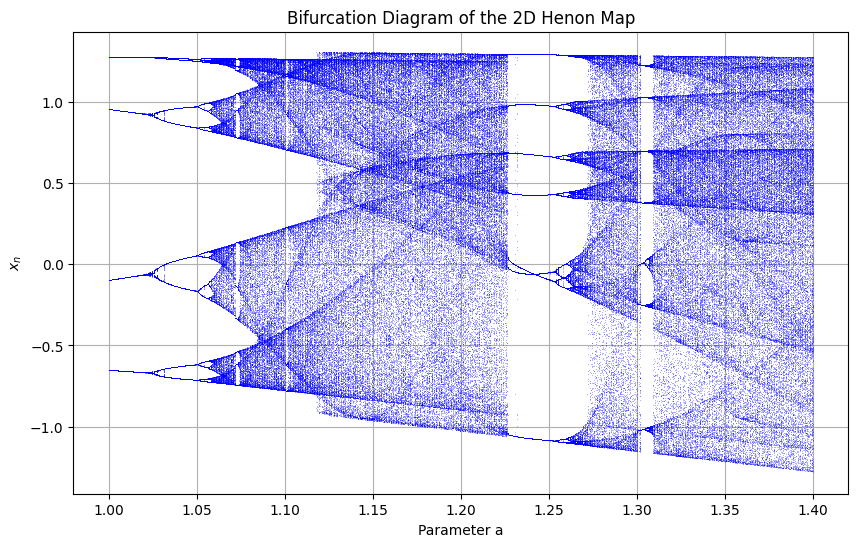

In [46]:
a_values = np.linspace(1.0, 1.4, 1000)
a_range, x_values = henon_bifurcation_diagram(a_values)

plt.figure(figsize=(10, 6))
plt.plot(a_range, x_values, ',b', alpha=0.3)
plt.xlabel("Parameter a")
plt.ylabel("$x_n$")
plt.title("Bifurcation Diagram of the 2D Henon Map")
plt.grid(True)
plt.show()


In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def calculate_entropy(image_array):
    """Calculate entropy of the image."""
    histogram, _ = np.histogram(image_array.flatten(), bins=256, range=(0, 256), density=True)
    histogram = histogram[histogram > 0]
    entropy = -np.sum(histogram * np.log2(histogram))
    return entropy

def calculate_npcr_uaci(cipher1, cipher2):
    """
    Calculate NPCR and UACI between two ciphertext images.
    These must be encryptions of two plaintext images that differ by only 1 pixel.

    Args:
        cipher1: np.ndarray — first encrypted image
        cipher2: np.ndarray — second encrypted image (from slightly perturbed plaintext)

    Returns:
        npcr: float — Number of Pixels Change Rate (%)
        uaci: float — Unified Average Changing Intensity (%)
    """
    if cipher1.shape != cipher2.shape:
        raise ValueError("Image dimensions must match")

    diff = cipher1 != cipher2
    npcr = np.sum(diff) / diff.size * 100

    abs_diff = np.abs(cipher1.astype(np.int16) - cipher2.astype(np.int16))
    uaci = np.sum(abs_diff) / (cipher1.size * 255) * 100

    return npcr, uaci

def visualize_images(img1, img2, title1="Image 1", title2="Image 2"):
    """Display side-by-side comparison of two images."""
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(img1, cmap='gray', vmin=0, vmax=255)
    axs[0].set_title(title1)
    axs[0].axis('off')

    axs[1].imshow(img2, cmap='gray', vmin=0, vmax=255)
    axs[1].set_title(title2)
    axs[1].axis('off')

    plt.tight_layout()
    plt.show()

def security_analysis(cipher_path_1, cipher_path_2):
    """
    Perform entropy, NPCR, and UACI analysis on two ciphertexts 
    (from one-pixel-different plaintexts).
    """
    cipher1 = np.array(Image.open(cipher_path_1).convert("L"))
    cipher2 = np.array(Image.open(cipher_path_2).convert("L"))

    entropy_val = calculate_entropy(cipher1)
    npcr_val, uaci_val = calculate_npcr_uaci(cipher1, cipher2)

    print(" Security Analysis Results:")
    print(f" Entropy (Image 1): {entropy_val:.4f} bits")
    print(f" NPCR:              {npcr_val:.2f} %")
    print(f" UACI:              {uaci_val:.2f} %")

    visualize_images(cipher1, cipher2, title1="Ciphertext 1", title2="Ciphertext 2")


256
65536
256
65536
 Security Analysis Results:
 Entropy (Image 1): 7.9970 bits
 NPCR:              99.62 %
 UACI:              33.40 %


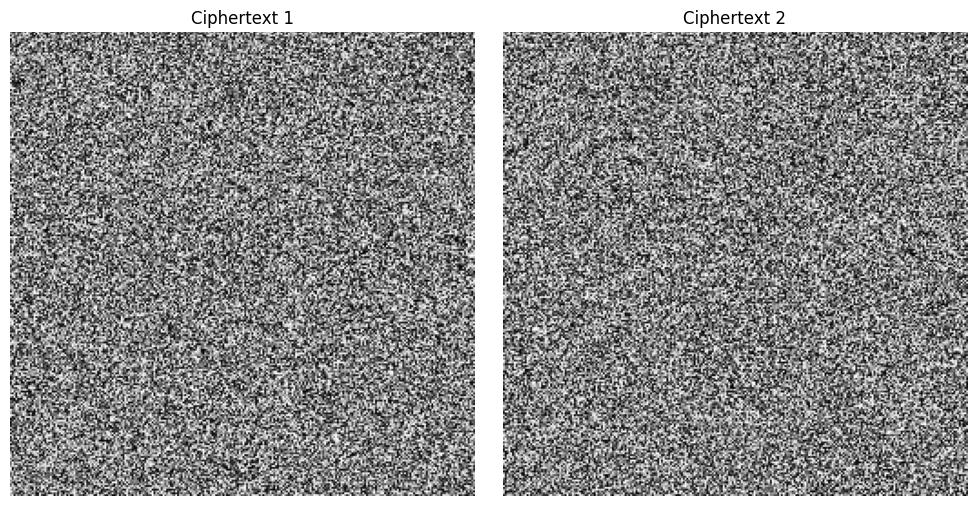

In [51]:
from PIL import Image
import numpy as np

# Load image from path and convert to array
# plainImg = r"C:\Users\User\Desktop\Images\256x256 grayscale\pepers\pepers_grayscale.png"
original_image = Image.open(plainImg).convert("L")
original_array = np.array(original_image)

# Slightly modify one pixel
modified_array = original_array.copy()
modified_array[0, 0] = (int(modified_array[0, 0]) + 1) % 256

# Save both original and modified versions to temporary files
Image.fromarray(original_array).save("temp_original.png")
Image.fromarray(modified_array).save("temp_modified.png")

# Encrypt both using the same encryption function
cipher1 = encrypt_image_variable_sbox_chunked(
    "temp_original.png", "cipher1.png", key,
    sbox_interval=1, x0_mask=0.5, r_mask=3.99
)

cipher2 = encrypt_image_variable_sbox_chunked(
    "temp_modified.png", "cipher2.png", key,
    sbox_interval=1, x0_mask=0.5, r_mask=3.99
)

# Run analysis on the ciphertexts
security_analysis("cipher1.png", "cipher2.png")


In [52]:
import numpy as np

# --- Logistic Map-based Permutation Generator ---
def logistic_permutation(length, x0=0.7, r=3.99):
    seq = np.zeros(length)
    for i in range(length):
        x0 = r * x0 * (1 - x0)
        seq[i] = x0
    return np.argsort(seq)

# Use same H and W from original image
h, w = 256, 256  # or read from original image

row_perm = logistic_permutation(h, x0=0.7, r=3.99)
col_perm = logistic_permutation(w, x0=(0.7 + 0.123456) % 1, r=3.99)
def logistic_permutation(length, x0=0.7, r=3.99):
    """Generate a permutation index array using a logistic map."""
    seq = np.zeros(length)
    x = x0
    for i in range(length):
        x = r * x * (1 - x)
        seq[i] = x
    perm = np.argsort(seq)
    return perm

# --- Apply Row and Column Permutation to Encrypted Image ---
def apply_logistic_shuffle(image_array, x0=0.7, r=3.99):
    """Apply logistic-map-based row and column shuffling."""
    shuffled = image_array.copy()
    h, w = image_array.shape[:2]

    # Generate permutations
    row_perm = logistic_permutation(h, x0, r)
    col_perm = logistic_permutation(w, (x0 + 0.123456) % 1, r)

    # Apply permutations
    shuffled = shuffled[row_perm, :]
    shuffled = shuffled[:, col_perm]

    return shuffled, row_perm, col_perm

# --- Unshuffle for Decryption ---
def inverse_permutation(perm):
    """Compute the inverse of a permutation."""
    inverse = np.empty_like(perm)
    for i, p in enumerate(perm):
        inverse[p] = i
    return inverse

def undo_logistic_shuffle(shuffled_array, row_perm, col_perm):
    """Undo logistic-map-based row and column shuffling."""
    unshuffled = shuffled_array.copy()
    inv_row = inverse_permutation(row_perm)
    inv_col = inverse_permutation(col_perm)

    unshuffled = unshuffled[inv_row, :]
    unshuffled = unshuffled[:, inv_col]

    return unshuffled


In [53]:
from PIL import Image

# Load encrypted image
img = np.array(Image.open(encryImg).convert("L"))

# Apply chaotic shuffling
shuffled_img, row_perm, col_perm = apply_logistic_shuffle(img)
# print(row_perm, col_perm)
# Save it
Image.fromarray(shuffled_img).save("shuffled_encrypted_baboon.png")


In [54]:
# Load shuffled encrypted image (after AES decryption but before unshuffle)
shuffled_img = np.array(Image.open("shuffled_encrypted_baboon.png").convert("L"))

# Undo the logistic shuffle
restored_img = undo_logistic_shuffle(shuffled_img, row_perm, col_perm)

# Save or compare with original
Image.fromarray(restored_img).save("unshuffled_restored_baboon.png")


In [56]:
def correlation_analysis(img):
    img = img.astype(np.int16)
    h, w = img.shape

    def corr(a, b):
        return np.corrcoef(a.flatten(), b.flatten())[0, 1]

    # Horizontal pairs
    horizontal = corr(img[:, :-1], img[:, 1:])
    # Vertical pairs
    vertical = corr(img[:-1, :], img[1:, :])
    # Diagonal pairs
    diagonal = corr(img[:-1, :-1], img[1:, 1:])

    print(" Correlation Coefficients:")
    print(f" Horizontal: {horizontal:.4f}")
    print(f" Vertical:   {vertical:.4f}")
    print(f"⤡ Diagonal:   {diagonal:.4f}")


In [57]:
shuffled = np.array(Image.open("shuffled_encrypted_baboon.png").convert("L"))
correlation_analysis(shuffled)


 Correlation Coefficients:
 Horizontal: -0.0008
 Vertical:   0.0023
⤡ Diagonal:   -0.0058


In [58]:
shuffled = np.array(Image.open(encryImg).convert("L"))
correlation_analysis(shuffled)


 Correlation Coefficients:
 Horizontal: 0.0021
 Vertical:   -0.0061
⤡ Diagonal:   -0.0064


In [59]:
!pip install pandas


[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536
256
65536


,Key_Byte_Pos,Trial,Flipped_Bits,Flip_Percentage
0,0,1,261717,49.918556
1,0,2,261965,49.965858
2,0,3,262349,50.039101
3,0,4,262197,50.010109
4,1,1,262293,50.028419
5,1,2,261297,49.838448
6,1,3,262390,50.046921
7,1,4,262635,50.093651
8,2,1,262367,50.042534
9,2,2,261573,49.891090


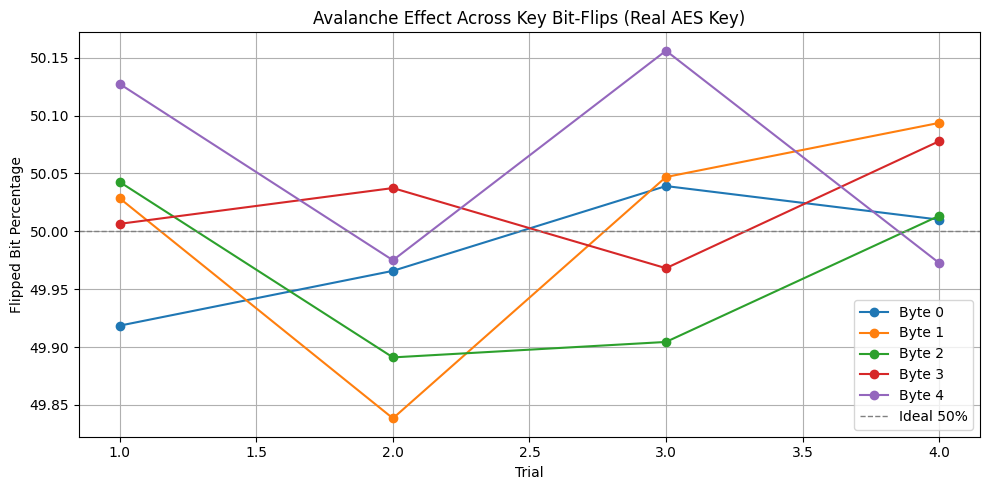

In [60]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

def test_avalanche_multiple_bits(image_path, key, flip_positions, trials=1):
    original_key = key.copy()

    # Encrypt once with original key
    encrypt_image_variable_sbox_chunked(image_path, "enc_original.png", original_key)
    enc1 = np.array(Image.open("enc_original.png")).flatten()

    results = []
    for pos in flip_positions:
        for trial in range(trials):
            flipped_key = original_key.copy()
            flipped_key[pos % len(flipped_key)] ^= (1 << (trial % 8))  # flip bit i in byte j

            encrypt_image_variable_sbox_chunked(image_path, "enc_flipped.png", flipped_key)
            enc2 = np.array(Image.open("enc_flipped.png")).flatten()

            xor = np.bitwise_xor(enc1, enc2)
            flipped_bits = np.unpackbits(xor).sum()
            total_bits = xor.size * 8
            flip_pct = 100 * flipped_bits / total_bits
            results.append({
                "Key_Byte_Pos": pos,
                "Trial": trial + 1,
                "Flipped_Bits": flipped_bits,
                "Flip_Percentage": flip_pct
            })

    df = pd.DataFrame(results)
    return df

# Real AES-128 Key
key_bytes = bytearray([
    0x2b, 0x7e, 0x15, 0x16,
    0x28, 0xae, 0xd2, 0xa6,
    0xab, 0xf7, 0x15, 0x88,
    0x09, 0xcf, 0x4f, 0x3c
])

# Run the test
flip_positions = list(range(5))
trials_per_bit = 4
df_avalanche_real = test_avalanche_multiple_bits("encrypted_baboon.png", key_bytes, flip_positions, trials=trials_per_bit)

# Display table
from IPython.display import display
display(df_avalanche_real)

# Plot chart
plt.figure(figsize=(10, 5))
for pos in flip_positions:
    subset = df_avalanche_real[df_avalanche_real["Key_Byte_Pos"] == pos]
    plt.plot(subset["Trial"], subset["Flip_Percentage"], marker='o', label=f'Byte {pos}')
plt.axhline(y=50, color='gray', linestyle='--', linewidth=1, label="Ideal 50%")
plt.title("Avalanche Effect Across Key Bit-Flips (Real AES Key)")
plt.xlabel("Trial")
plt.ylabel("Flipped Bit Percentage")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("avalanche_effect_plot.png", dpi=300)
plt.show()


In [61]:
from PIL import Image
import numpy as np
from skimage.metrics import structural_similarity as ssim

def test_key_sensitivity(
    image_path: str,
    key: bytes,
    altered_key: bytes,
    x0: float,
    x0_mask: float,
    r_mask: float,
    altered_param: dict,
    encrypt_fn,
    decrypt_fn
):
    enc_path = "encrypted_original.png"
    dec_path_original = "decrypted_original.png"
    dec_path_altered = "decrypted_altered.png"

    # Step 1: Encrypt with original key and parameters
    meta = encrypt_fn(
        image_path=image_path,
        output_path=enc_path,
        key=key,
        shift_pattern=None,
        sbox_interval=1,
        x0_mask=x0_mask,
        r_mask=r_mask
    )

    # Step 2: Decrypt with correct key
    decrypt_fn(
        encrypted_path=enc_path,
        output_path=dec_path_original,
        key=key,
        meta=meta,
        sbox_interval=1
    )

    # Step 3: Decrypt with altered key or altered chaotic params
    altered_meta = meta.copy()
    altered_meta["initial_x0"] = altered_param.get("x0", x0)
    altered_meta["x0_mask"] = altered_param.get("x0_mask", x0_mask)
    altered_meta["r_mask"] = altered_param.get("r_mask", r_mask)

    decrypt_fn(
        encrypted_path=enc_path,
        output_path=dec_path_altered,
        key=altered_key,
        meta=altered_meta,
        sbox_interval=1
    )

    # Step 4: Compare SSIM between original and altered decryption
    original = np.array(Image.open(dec_path_original).convert("L"))
    altered = np.array(Image.open(dec_path_altered).convert("L"))

    score = ssim(original, altered)
    return score


In [62]:
key_bytes = bytes(key)


In [63]:
altered_key = key.copy()
altered_key[-1] = 0x3d  # only 1-bit difference from original (0x3c)

key_bytes = bytes(key)
altered_key_bytes = bytes(altered_key)


In [64]:
plainImg = r"C:\Users\User\Desktop\Images\256x256 grayscale\Baboon\Baboon-grayscale.png"

In [65]:
ssim_val = test_key_sensitivity(
    image_path=plainImg,
    key=key_bytes,
    altered_key=altered_key_bytes,
    x0=0.5,
    x0_mask=0.5,
    r_mask=3.99,
    altered_param={},  # key only changed
    encrypt_fn=encrypt_image_variable_sbox_chunked,
    decrypt_fn=decrypt_image_variable_sbox_chunked
)

print("SSIM with 1-byte changed AES key:", ssim_val)


256
65536
256 256 1
encrypted_original.png
256 256 1
encrypted_original.png
SSIM with 1-byte changed AES key: 0.010545747535904213


In [66]:
import numpy as np
from PIL import Image
import cv2

def compute_npcr_uaci(img1, img2):
    """Compute NPCR and UACI between two encrypted images."""
    assert img1.shape == img2.shape, "Image sizes must match"
    M, N = img1.shape

    # NPCR
    diff = img1 != img2
    npcr = np.sum(diff) / (M * N) * 100

    # UACI
    uaci = np.sum(np.abs(img1 - img2) / 255.0) / (M * N) * 100

    return npcr, uaci


def run_differential_attack_test(image_path, key, x0, x0_mask, r_mask, encrypt_fn):
    """
    Perform differential attack test:
    - Encrypt original image (C1)
    - Modify 1 pixel
    - Encrypt modified image (C2)
    - Compare C1 and C2 using NPCR and UACI
    """
    orig_img = Image.open(image_path).convert("L")
    orig_array = np.array(orig_img)
    mod_array = orig_array.copy()

    # Flip one pixel (e.g., increment by 1)
    i, j = 0, 0  # top-left pixel
    if mod_array[i, j] == 255:
        mod_array[i, j] = 0
    else:
        mod_array[i, j] += 1


    # Save modified image temporarily
    modified_path = "temp_modified.png"
    Image.fromarray(mod_array).save(modified_path)

    # Encrypt original
    meta1 = encrypt_fn(
        image_path=image_path,
        output_path="enc_original.png",
        key=key,
        shift_pattern=None,
        sbox_interval=1,
        x0_mask=x0_mask,
        r_mask=r_mask
    )

    # Encrypt modified
    meta2 = encrypt_fn(
        image_path=modified_path,
        output_path="enc_modified.png",
        key=key,
        shift_pattern=None,
        sbox_interval=1,
        x0_mask=x0_mask,
        r_mask=r_mask
    )

    # Load encrypted images
    enc1 = np.array(Image.open("enc_original.png").convert("L"))
    enc2 = np.array(Image.open("enc_modified.png").convert("L"))

    npcr, uaci = compute_npcr_uaci(enc1, enc2)
    return npcr, uaci


In [67]:


x0 = 0.5
x0_mask = 0.5
r_mask = 3.99

# Run differential test
npcr, uaci = run_differential_attack_test(
    image_path=plainImg,
    key=key_bytes,
    x0=x0,
    x0_mask=x0_mask,
    r_mask=r_mask,
    encrypt_fn=encrypt_image_variable_sbox_chunked
)




256
65536
256
65536


In [68]:
def add_noise_to_image(image_path, output_path, noise_type="salt_pepper", amount=0.05):
    img = np.array(Image.open(image_path).convert("L")) / 255.0

    if noise_type == "salt_pepper":
        noisy = img.copy()
        num_pixels = int(amount * img.size)
        coords = np.random.randint(0, img.shape[0], (num_pixels, 2))
        for x, y in coords:
            noisy[x % img.shape[0], y % img.shape[1]] = np.random.choice([0, 1])
    elif noise_type == "gaussian":
        noise = np.random.normal(0, 0.1, img.shape)
        noisy = np.clip(img + noise, 0, 1)
    else:
        raise ValueError("Unknown noise type")

    Image.fromarray((noisy * 255).astype(np.uint8)).save(output_path)


In [69]:
# Encrypt
meta = encrypt_image_variable_sbox_chunked(
    image_path=plainImg,
    output_path="encrypted_p.png",
    key=key_bytes,
    sbox_interval=1
)

# Add noise to encrypted image
add_noise_to_image("encrypted_p.png", "encrypted_noisy_p.png", noise_type="salt_pepper", amount=0.01)

# Attempt to decrypt the noisy cipher image
decrypted_noisy = decrypt_image_variable_sbox_chunked(
    encrypted_path="encrypted_noisy_p.png",
    output_path="decrypted_noisy_p.png",
    key=key_bytes,
    meta=meta,
    sbox_interval=1
)

# Compare original vs noisy-decrypted image
original = np.array(Image.open(plainImg).convert("L"))
decrypted_noisy = np.array(Image.open("decrypted_noisy_p.png").convert("L"))

ssim_val = ssim(original, decrypted_noisy)
print(f"SSIM after noise attack: {ssim_val:.6f}")


256
65536
256 256 1
encrypted_noisy_p.png
SSIM after noise attack: 0.229311


In [70]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def logistic_map_sequence(length, x0=0.5, r=3.99, discard=100):
    x = x0
    seq = []
    for i in range(length + discard):
        x = r * x * (1 - x)
        if i >= discard:
            seq.append(x)
    return np.array(seq)

def add_gaussian_noise(image_path, output_path, sigma=0.1):
    """
    Adds Gaussian noise to a grayscale image.
    """
    img = np.array(Image.open(image_path).convert("L"), dtype=np.float32) / 255.0
    noise = np.random.normal(0, sigma, img.shape)
    noisy_img = np.clip(img + noise, 0, 1)
    Image.fromarray((noisy_img * 255).astype(np.uint8)).save(output_path)

def noise_attack_analysis_gaussian(original_path, encrypted_path, noisy_output_path, decrypted_output_path,
                                    key, meta, decrypt_fn, sigma=0.1):
    """
    Tests noise attack resistance by applying Gaussian noise to cipher and comparing decrypted result.
    """
    # Step 1: Add Gaussian noise to the encrypted image
    add_gaussian_noise(encrypted_path, noisy_output_path, sigma=sigma)

    # Step 2: Attempt to decrypt the noisy cipher
    decrypt_fn(
        encrypted_path=noisy_output_path,
        output_path=decrypted_output_path,
        key=key,
        meta=meta,
        sbox_interval=1
    )

    # Step 3: Load original and noisy-decrypted image
    original = np.array(Image.open(original_path).convert("L"))
    decrypted = np.array(Image.open(decrypted_output_path).convert("L"))

    # Step 4: Compute SSIM
    score = ssim(original, decrypted)

    # Step 5: Show side-by-side comparison
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    axes[0].imshow(original, cmap='gray')
    axes[0].set_title("Original Image")
    axes[0].axis("off")

    axes[1].imshow(decrypted, cmap='gray')
    axes[1].set_title(f"Noisy Decrypted\nSSIM: {score:.4f}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.show()

    return score


256 256 1
encrypted_baboon_noisy.png


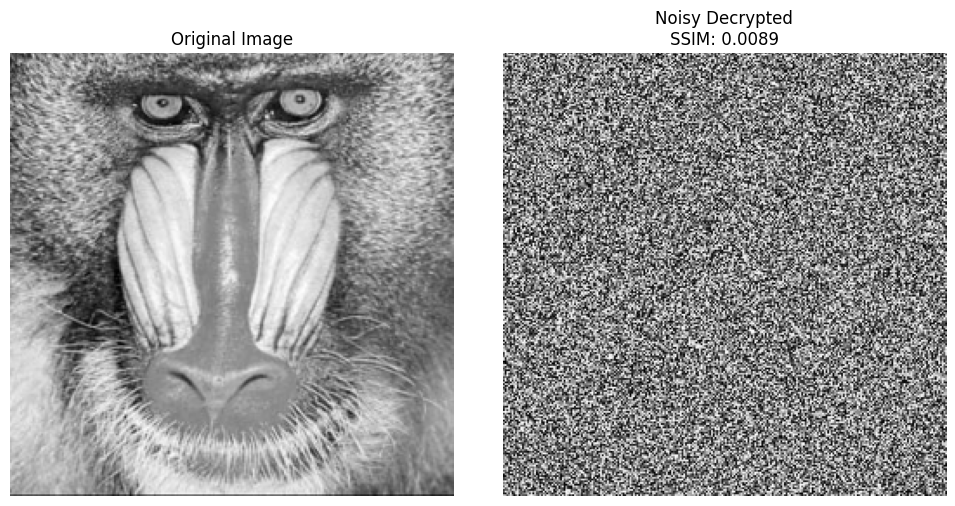

SSIM after Gaussian noise attack: 0.008923


In [71]:
ssim_score = noise_attack_analysis_gaussian(
    original_path=plainImg,
    encrypted_path=encryImg,
    noisy_output_path="encrypted_baboon_noisy.png",
    decrypted_output_path="decrypted_baboon_noisy.png",
    key=key_bytes,
    meta=meta,
    decrypt_fn=decrypt_image_variable_sbox_chunked,
    sigma=0.1  # adjust for different noise levels
)

print(f"SSIM after Gaussian noise attack: {ssim_score:.6f}")


In [73]:
from PIL import Image
import numpy as np
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr(original_path, decrypted_path):
    """
    Computes PSNR between two grayscale images.
    """
    original = np.array(Image.open(original_path).convert("L"))
    decrypted = np.array(Image.open(decrypted_path).convert("L"))
    return psnr(original, decrypted)


In [74]:
score = compute_psnr(plainImg, "decrypted_baboon_noisy.png")
print(f"PSNR after noise attack: {score:.2f} dB")


PSNR after noise attack: 9.74 dB


In [75]:






### Data LOSS

In [76]:
import numpy as np
from PIL import Image
import random

def simulate_data_loss(image_path, output_path, loss_type="block", loss_ratio=0.2, block_size=16):
    img = Image.open(image_path).convert("L")
    img_array = np.array(img)

    h, w = img_array.shape
    damaged = img_array.copy()

    if loss_type == "block":
        num_blocks = int((h // block_size) * (w // block_size) * loss_ratio)
        for _ in range(num_blocks):
            i = random.randint(0, h - block_size)
            j = random.randint(0, w - block_size)
            damaged[i:i+block_size, j:j+block_size] = 0

    elif loss_type == "pixel":
        num_pixels = int(h * w * loss_ratio)
        for _ in range(num_pixels):
            i = random.randint(0, h - 1)
            j = random.randint(0, w - 1)
            damaged[i, j] = 0

    else:
        raise ValueError("Invalid loss_type. Use 'block' or 'pixel'.")

    Image.fromarray(damaged).save(output_path)


In [77]:
def evaluate_data_loss_attack_multiple_runs(original_path, encrypted_path, decrypt_fn, key, meta,
                                            loss_ratio=0.2, loss_type="block", runs=10):
    ssim_scores = []
    psnr_scores = []

    for i in range(runs):
        damaged_path = f"encrypted_dataloss_run{i}.png"
        decrypted_path = f"decrypted_dataloss_run{i}.png"

    # Generate a simulated damaged encrypted image
        simulate_data_loss(encrypted_path, damaged_path, loss_type=loss_type, loss_ratio=loss_ratio)

    # Try decrypting the damaged image
        decrypt_fn(
        encrypted_path=damaged_path,
        output_path=decrypted_path,
        key=key,
        meta=meta,
        sbox_interval=1
    )
        original = np.array(Image.open(original_path).convert("L"))
        decrypted = np.array(Image.open(decrypted_path).convert("L"))

        ssim_score = ssim(original, decrypted)
        psnr_score = psnr(original, decrypted)

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)

    ssim_mean = np.mean(ssim_scores)
    ssim_std = np.std(ssim_scores)
    psnr_mean = np.mean(psnr_scores)
    psnr_std = np.std(psnr_scores)

    return ssim_mean, ssim_std, psnr_mean, psnr_std


In [78]:
import matplotlib.pyplot as plt

def visualize_data_loss_attack(original_path, encrypted_path, damaged_path, decrypted_path):
    original = np.array(Image.open(original_path).convert("L"))
    encrypted = np.array(Image.open(encrypted_path).convert("L"))
    damaged = np.array(Image.open(damaged_path).convert("L"))
    decrypted = np.array(Image.open(decrypted_path).convert("L"))

    fig, axs = plt.subplots(1, 4, figsize=(16, 4))

    axs[0].imshow(original, cmap="gray")
    axs[0].set_title("(a) Original Image")
    axs[0].axis("off")

    axs[1].imshow(encrypted, cmap="gray")
    axs[1].set_title("(b) Encrypted Image")
    axs[1].axis("off")

    axs[2].imshow(damaged, cmap="gray")
    axs[2].set_title("(c) Encrypted with Data Loss")
    axs[2].axis("off")

    axs[3].imshow(decrypted, cmap="gray")
    axs[3].set_title("(d) Decrypted Image")
    axs[3].axis("off")

    plt.tight_layout()
    plt.savefig("dataloss_attack_analysis.png", dpi=300)
    plt.show()

    print("✅ Visualization saved as dataloss_attack_analysis.png")


256 256 1
encrypted_dataloss_run0.png


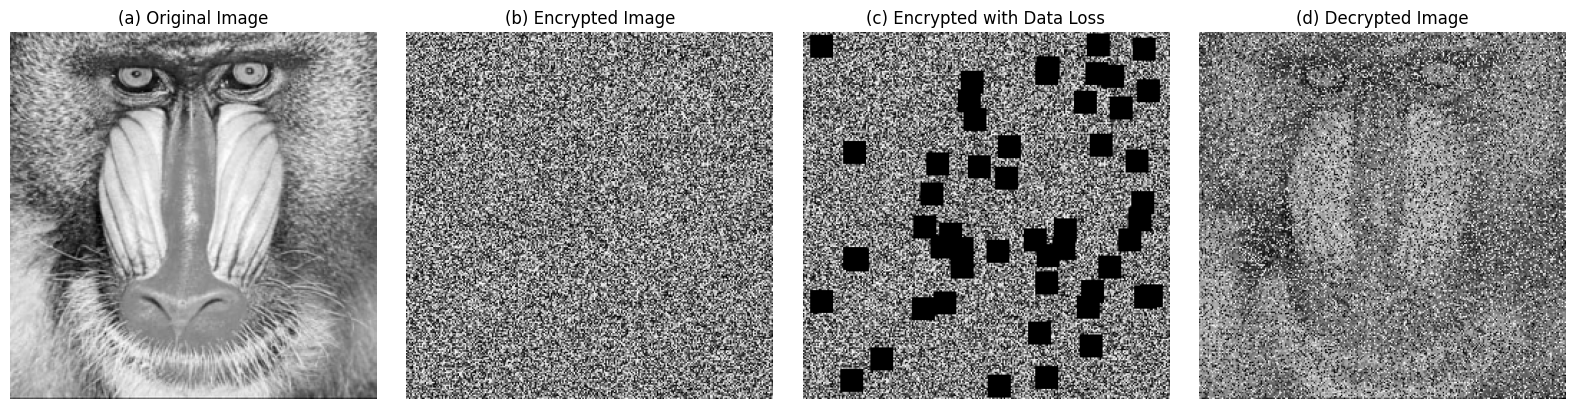

✅ Visualization saved as dataloss_attack_analysis.png


In [79]:
# Prepare one sample to visualize (you can reuse from previous loop or regenerate)
simulate_data_loss("encrypted_baboon.png", "encrypted_dataloss_run0.png", loss_type="block", loss_ratio=0.2)

decrypt_image_variable_sbox_chunked(
    encrypted_path="encrypted_dataloss_run0.png",
    output_path="decrypted_dataloss_run0.png",
    key=key_bytes,
    meta=meta,
    sbox_interval=1
)

visualize_data_loss_attack(
    original_path=plainImg,
    encrypted_path="encrypted_baboon.png",
    damaged_path="encrypted_dataloss_run0.png",
    decrypted_path="decrypted_dataloss_run0.png"
)


In [80]:
ssim_mean, ssim_std, psnr_mean, psnr_std = evaluate_data_loss_attack_multiple_runs(
    original_path=plainImg,
    encrypted_path=encryImg,
    decrypt_fn=decrypt_image_variable_sbox_chunked,
    key=key_bytes,
    meta=meta,
    loss_ratio=0.2,
    loss_type="block",
    runs=10
)

print(f"Average SSIM: {ssim_mean:.4f} ± {ssim_std:.4f}")
print(f"Average PSNR: {psnr_mean:.2f} dB ± {psnr_std:.2f} dB")


256 256 1
encrypted_dataloss_run0.png
256 256 1
encrypted_dataloss_run1.png
256 256 1
encrypted_dataloss_run2.png
256 256 1
encrypted_dataloss_run3.png
256 256 1
encrypted_dataloss_run4.png
256 256 1
encrypted_dataloss_run5.png
256 256 1
encrypted_dataloss_run6.png
256 256 1
encrypted_dataloss_run7.png
256 256 1
encrypted_dataloss_run8.png
256 256 1
encrypted_dataloss_run9.png
Average SSIM: 0.1239 ± 0.0060
Average PSNR: 12.88 dB ± 0.12 dB


In [83]:
def quantize(img, levels=16):
    """
    Quantize the image to the given number of gray levels.
    """
    bins = np.linspace(0, 256, levels + 1)
    quantized = np.digitize(img, bins) - 1
    return quantized

In [84]:
def compute_glcm_single_image(image, levels=256, dx=1, dy=0):
    """
    Compute GLCM within a single image using spatial offsets.
    For example, dx=1, dy=0 gives horizontal pairs.
    """
    h, w = image.shape
    glcm = np.zeros((levels, levels), dtype=np.float64)

    for i in range(h - dy):
        for j in range(w - dx):
            row = image[i, j]
            col = image[i + dy, j + dx]
            glcm[row, col] += 1

    glcm /= glcm.sum()  # normalize
    return glcm
# Quantize for stability
# Load image and convert to grayscale
img_encrypted = np.array(Image.open(encryImg).convert("L"))

# Quantize the grayscale image
img_encrypted_q = quantize(img_encrypted, levels=8)

# Compute GLCM with spatial correlation (horizontal neighbors)
glcm_enc = compute_glcm_single_image(img_encrypted_q, levels=8, dx=1, dy=0)
h_encrypted = compute_homogeneity(glcm_enc)

print(f"✅ Homogeneity (encrypted image, internal spatial correlation): {h_encrypted:.4f}")



NameError: name 'compute_homogeneity' is not defined

In [ ]:
import numpy as np
from PIL import Image



def compute_glcm(image, levels=16):
    """
    Compute the GLCM of the image with horizontal adjacency (0,1).
    Returns a normalized GLCM matrix.
    """
    glcm = np.zeros((levels, levels), dtype=np.float64)
    rows, cols = image.shape

    for i in range(rows):
        for j in range(cols - 1):  # horizontal adjacency
            a = image[i, j]
            b = image[i, j + 1]
            glcm[a, b] += 1

    glcm /= glcm.sum()  # Normalize
    return glcm

def compute_energy(glcm):
    """
    Compute energy = sum of squared GLCM values.
    """
    return np.sum(glcm ** 2)

# ======= MAIN ANALYSIS =======

# Load grayscale images
plain_path = plainImg
encrypted_path = encryImg

img_plain = np.array(Image.open(plain_path).convert("L"))
img_encrypted = np.array(Image.open(encrypted_path).convert("L"))

# Set gray levels
levels = 16

# Quantize images
img_plain_q = quantize(img_plain, levels=levels)
img_encrypted_q = quantize(img_encrypted, levels=levels)

# Compute GLCM and energy
glcm_plain = compute_glcm(img_plain_q, levels=levels)
glcm_encrypted = compute_glcm(img_encrypted_q, levels=levels)

energy_plain = compute_energy(glcm_plain)
energy_encrypted = compute_energy(glcm_encrypted)

# Output results
print(f"Energy of the plaintext image:  {energy_plain:.4f}")
print(f"Energy of the encrypted image: {energy_encrypted:.4f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def show_and_save_cropping_attack_figure(original_path, encrypted_path, decrypt_fn, key, meta,
                                         crop_size=(50, 50), start=(100, 100), sbox_interval=1,
                                         save_path="cropping_attack_analysis.png"):
    # Load images
    original = Image.open(original_path).convert("L")
    encrypted = Image.open(encrypted_path).convert("L")

    original_np = np.array(original)
    encrypted_np = np.array(encrypted)

    h, w = crop_size
    y, x = start

    # Step (c): Create cropped encrypted image with white square
    cropped_encrypted_np = encrypted_np.copy()
    cropped_encrypted_np[y:y+h, x:x+w] = 255

    # Save only the cropped region to decrypt
    cropped_patch = encrypted_np[y:y+h, x:x+w]
    cropped_patch_path = "cropped_patch.png"
    Image.fromarray(cropped_patch).save(cropped_patch_path)

    # Prepare metadata for decrypting just the cropped patch
    total_pixels = h * w
    padded_len = ((total_pixels + 15) // 16) * 16
    padding = padded_len - total_pixels

    cropped_meta = {
        "original_shape": (h, w, 1),
        "padding": padding,
        "initial_x0": meta["initial_x0"],
        "initial_y0": meta["initial_y0"],
        "x0_mask": meta["x0_mask"],
        "r_mask": meta["r_mask"],
        "perm_indices": meta["perm_indices"][:padded_len],
        "iv": meta["iv"],
        "seed": meta["seed"]
    }

    # Decrypt the cropped patch
    decrypt_fn(cropped_patch_path, "decrypted_patch.png", key, cropped_meta, sbox_interval)
    decrypted_patch = np.array(Image.open("decrypted_patch.png").convert("L"))

    # Create final decrypted image (insert patch back)
    decrypted_full = encrypted_np.copy()
    decrypted_full[y:y+h, x:x+w] = decrypted_patch

    # Plot and save figure
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(original_np, cmap="gray")
    axs[0].set_title("(a) Original Image")
    axs[0].axis("off")

    axs[1].imshow(encrypted_np, cmap="gray")
    axs[1].set_title("(b) Encrypted Image")
    axs[1].axis("off")

    axs[2].imshow(cropped_encrypted_np, cmap="gray")
    axs[2].set_title("(c) Cropped Image")
    axs[2].axis("off")

    axs[3].imshow(decrypted_full, cmap="gray")
    axs[3].set_title("(d) Decrypted Image")
    axs[3].axis("off")

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

    print(f" Cropping attack figure saved as: {save_path}")


In [ ]:
show_and_save_cropping_attack_figure(
    original_path=plainImg,
    encrypted_path="encrypted_baboon.png",
    decrypt_fn=decrypt_image_variable_sbox_chunked,
    key=key,
    meta=meta,
    crop_size=(50, 50),
    start=(100, 100),
    sbox_interval=1,
    save_path="cropping_attack_analysis.png"
)


In [ ]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

def simulate_xor_noise_attack(encrypted_path, output_path, noise_value=0x0E):
    """
    Simulates noise attack by XORing the encrypted image with a fixed noise value.
    """
    img = Image.open(encrypted_path).convert("L")
    img_np = np.array(img, dtype=np.uint8)

    # Apply XOR operation
    noisy_img_np = np.bitwise_xor(img_np, noise_value)

    # Save the result
    Image.fromarray(noisy_img_np).save(output_path)
    return noisy_img_np

def perform_noise_attack_analysis(original_path, encrypted_path, decrypt_fn, key, meta, noise_value=0x0E):
    """
    Visualizes and evaluates the effect of XOR-based noise on ciphertext and its impact on decryption.
    """
    # Step 1: Simulate noisy ciphertext
    noisy_encrypted_path = "encrypted_with_xor_noise.png"
    simulate_xor_noise_attack(encrypted_path, noisy_encrypted_path, noise_value=noise_value)

    # Step 2: Decrypt the noisy ciphertext
    decrypted_path = "decrypted_from_xor_noisy_cipher.png"
    decrypt_fn(
        encrypted_path=noisy_encrypted_path,
        output_path=decrypted_path,
        key=key,
        meta=meta,
        sbox_interval=1
    )

    # Load images
    original = np.array(Image.open(original_path).convert("L"))
    encrypted = np.array(Image.open(encrypted_path).convert("L"))
    noisy_encrypted = np.array(Image.open(noisy_encrypted_path).convert("L"))
    decrypted = np.array(Image.open(decrypted_path).convert("L"))

    # Compute metrics
    ssim_val = ssim(original, decrypted, data_range=255)
    psnr_val = psnr(original, decrypted, data_range=255)

    # Visualization
    fig, axs = plt.subplots(1, 4, figsize=(16, 4))
    axs[0].imshow(original, cmap='gray')
    axs[0].set_title("(a) Original Image")
    axs[0].axis("off")

    axs[1].imshow(encrypted, cmap='gray')
    axs[1].set_title("(b) Encrypted Image")
    axs[1].axis("off")

    axs[2].imshow(noisy_encrypted, cmap='gray')
    axs[2].set_title("(c) Encrypted + XOR Noise")
    axs[2].axis("off")

    axs[3].imshow(decrypted, cmap='gray')
    axs[3].set_title("(d) Decrypted from Noisy Cipher")
    axs[3].axis("off")

    plt.tight_layout()
    plt.savefig("xor_noise_attack_analysis.png", dpi=300)
    plt.show()

    print(f"SSIM: {ssim_val:.4f}, PSNR: {psnr_val:.2f} dB")
    print(" Figure saved as xor_noise_attack_analysis.png")


In [ ]:
perform_noise_attack_analysis(
    original_path=r"C:\Users\User\Desktop\Images\256x256 grayscale\lena\lena-grayscale.png",
    encrypted_path="encrypted_lena.png",
    decrypt_fn=decrypt_image_variable_sbox_chunked,
    key=key_bytes,
    meta=meta,
    noise_value=0xFF  
)
